In [164]:
import sim
import time
import cv2
import numpy as np
from PIL import Image
from queue import PriorityQueue
import math
from numpy import sqrt
import itertools

In [165]:
def resize(img,resolution):
    scale_percent = 500 # percent of original size
    width = int(resolution[1] * scale_percent / 100)
    height = int(resolution[0] * scale_percent / 100)
    dim = (width, height)
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    return resized
def x_w_i(w_x):
    y=((w_x+2.5)*1280)/5
    return round(y)
def y_w_i(w_y):
    x=((2.5-w_y)*1280)/5
    return round(x)
def x_i_w(i_x):
    y=(i_x*5/1280)-2.5
    return y
def y_i_w(i_y):
    x=(2.5)-(i_y*5/1280)
    return x
def draw_rec_red(x,image):
    for i in range(120):
         for j in range(120):
                if (0<x[0]-60+i<1280 and 0<x[1]-60+j<1280):
                    image[x[0]-60+i][x[1]-60+j]=(255,0,0)

def draw_rec_blue(x,image): 
    for i in range(120):
         for j in range(120):
                if (0<x[0]-60+i<1280 and 0<x[1]-60+j<1280):
                    image[x[0]-60+i][x[1]-60+j]=(0,0,255)
                    
                    
def draw_rec_green(x,image):
    for i in range(120):
         for j in range(120):
                if (0<x[0]-60+i<1280 and 0<x[1]-60+j<1280):
                    image[x[0]-60+i][x[1]-60+j]=(0,255,0)
                    
                    
def my_range(start, end, step):
    while start <= end:
        yield start
        start += step

def obstacles_grid(img):
    # getting the walls 
    mask_wall = cv2.inRange(img, np.array([228,228,253]),np.array([230,230,2256]))
    # getting the rims
    mask_rim = cv2.inRange(img, 0, 0)
    mask_total = cv2.bitwise_or(mask_wall,mask_rim,mask_rim)
    mask_total = cv2.bitwise_not(mask_total)
    return mask_total

def distu(x,y):
    dist = sqrt( (x[0] - y[0])**2 + (x[1] - y[1])**2 )
    return round(dist)


def get(array):
    array.sort()
    return array.pop(0)
    

def put(array,data):
    array.append(data)
    array.sort()
    return array

def expand(s):
    aa=[]
    for row in s:
        for a_a in row[1:]:
            aa.append(a_a)
    return aa
def man_dis(x,y):
    x1,y1=x
    x2,y2=y
    return abs(x1-x2)+abs(y1-y2)

def conv(s):
    g=round((s/128)-0.5)
    return g
def incov(s):
    g=(s+0.5)*128
    return g


def neighbours(x,img_obs):
    neigh=[]
    kk=[-128,0,128]
    for i in kk:
        for j in kk:
            if i==0 and j==0:
                continue
            else:
                if (0<(x[0]+i)) and ((x[0]+i)<=1280) and (0<(x[1]+j))and((x[1]+j)<=1280):
                            if img_obs[x[0]+i][x[1]+j]!=0:
                                neigh.append([x[0]+i,x[1]+j])
    return neigh
                            

In [166]:

sim.simxFinish(-1)
scale_percent =600
clientID = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)
thistime = time.time()
if clientID != -1:
    res_ro, robot = sim.simxGetObjectHandle(clientID, 'Pioneer_p3dx', sim.simx_opmode_oneshot_wait)
    res_l,right_motor_handle = sim.simxGetObjectHandle(clientID,'Pioneer_p3dx_rightMotor',sim.simx_opmode_oneshot_wait)
    res_r,left_motor_handle = sim.simxGetObjectHandle(clientID,'Pioneer_p3dx_leftMotor',sim.simx_opmode_oneshot_wait)
    res_floor,floor=sim.simxGetObjectHandle(clientID,'ResizableFloor_5_25',sim.simx_opmode_blocking)
    res,camera = sim.simxGetObjectHandle(clientID, 'ss', sim.simx_opmode_oneshot_wait)
    err, resolution, image = sim.simxGetVisionSensorImage(clientID, camera, 0, sim.simx_opmode_streaming)
    while (sim.simxGetConnectionId(clientID) != -1):
        res_pos,pos=sim.simxGetObjectPosition(clientID,robot,-1,sim.simx_opmode_oneshot_wait)
        res_or,orien=sim.simxGetObjectOrientation(clientID,robot,-1,sim.simx_opmode_oneshot_wait)
        print(pos)
        #print(orien)
        err, resolution, image = sim.simxGetVisionSensorImage(clientID, camera, 0, sim.simx_opmode_buffer)
        if err == sim.simx_return_ok:
            img = np.array(image, dtype=np.uint8)
            img.resize([resolution[0], resolution[1], 3]) 
            resized=resize(img,resolution)
            image = Image.fromarray(resized, 'RGB')
        sim.simxFinish(clientID)
img_obs = obstacles_grid(resized)
xs=x_w_i(pos[0])
ys=y_w_i(pos[1])
start=[xs,ys]
goal=[x_w_i(-2.25),y_w_i(2.25)]


[2.2457165718078613, -2.2516067028045654, 0.13864664733409882]


In [167]:
parent=np.array([[[0,0]]*10]*10)
def djikstra(start,goal,resized,img_obs):
    dist = np.array([[np.inf]*10]*10)
    a,b=conv(start[0]),conv(start[1])
    dist[a][b]=0
    closed=[]
    open_l=[]
    for i in range(len(parent)):
        for j in range(len(parent[i])):
            if img_obs[int((i+0.5)*128)][int((j+0.5)*128)]!=0:
                open_l.append([dist[i][j],[(i+0.5)*128,(j+0.5)*128]])
    while open_l:
        print(parent)
        node=get(open_l)
        node_1=node[1]
        node1=[int(node_1[0]),int(node_1[1])]
        draw_rec_red(node1,resized)
        print(node1)
        distance=dist[conv(node1[0])][conv(node1[1])]
        print(distance)
        closed.append(node1)
        nei=neighbours(node1,img_obs)
        print(nei)
        for ne in nei:
            draw_rec_red(ne,resized)
            print(ne)
            if ne not in closed:
                print(distu(node1,ne))
                d=distance+distu(node1,ne)
                if d <  dist[conv(ne[0])][conv(ne[1])]:
                    dist[conv(ne[0])][conv(ne[1])]=d
                    parent[conv(ne[0])][conv(ne[1])]=node1
                    for ro in open_l:
                        if ro[-1]==ne:
                            ro[0]=d
                    
                    
                
        
    
djikstra(start,goal,resized,img_obs)

[[[0 0]
  [0 0]
  [0 0]
  [0 0]
  [0 0]
  [0 0]
  [0 0]
  [0 0]
  [0 0]
  [0 0]]

 [[0 0]
  [0 0]
  [0 0]
  [0 0]
  [0 0]
  [0 0]
  [0 0]
  [0 0]
  [0 0]
  [0 0]]

 [[0 0]
  [0 0]
  [0 0]
  [0 0]
  [0 0]
  [0 0]
  [0 0]
  [0 0]
  [0 0]
  [0 0]]

 [[0 0]
  [0 0]
  [0 0]
  [0 0]
  [0 0]
  [0 0]
  [0 0]
  [0 0]
  [0 0]
  [0 0]]

 [[0 0]
  [0 0]
  [0 0]
  [0 0]
  [0 0]
  [0 0]
  [0 0]
  [0 0]
  [0 0]
  [0 0]]

 [[0 0]
  [0 0]
  [0 0]
  [0 0]
  [0 0]
  [0 0]
  [0 0]
  [0 0]
  [0 0]
  [0 0]]

 [[0 0]
  [0 0]
  [0 0]
  [0 0]
  [0 0]
  [0 0]
  [0 0]
  [0 0]
  [0 0]
  [0 0]]

 [[0 0]
  [0 0]
  [0 0]
  [0 0]
  [0 0]
  [0 0]
  [0 0]
  [0 0]
  [0 0]
  [0 0]]

 [[0 0]
  [0 0]
  [0 0]
  [0 0]
  [0 0]
  [0 0]
  [0 0]
  [0 0]
  [0 0]
  [0 0]]

 [[0 0]
  [0 0]
  [0 0]
  [0 0]
  [0 0]
  [0 0]
  [0 0]
  [0 0]
  [0 0]
  [0 0]]]
[1216, 1216]
0.0
[[1088, 1088], [1088, 1216], [1216, 1088]]
[1088, 1088]
181.0
[1088, 1216]
128.0
[1216, 1088]
128.0
[[[   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0

[1216, 1088]
[[[   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]]

 [[   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]]

 [[   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]]

 [[   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]]

 [[   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]]

 [[   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]]

 [[   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0  

[1088, 832]
[1216, 576]
128.0
[1216, 832]
[[[   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]]

 [[   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]]

 [[   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]]

 [[   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]]

 [[   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]]

 [[   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]]

 [[   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0 

[832, 320]
181.0
[832, 448]
128.0
[960, 320]
128.0
[960, 576]
[1088, 320]
181.0
[1088, 448]
[1088, 576]
[[[   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]]

 [[   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]]

 [[   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]]

 [[   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]]

 [[   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]]

 [[   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]]

 [[   0    0]
  [   0    0]
  [ 960  448]
  

[704, 448]
[832, 192]
128.0
[832, 448]
[960, 192]
181.0
[960, 320]
[960, 448]
[[[   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]]

 [[   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]]

 [[   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]]

 [[   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]]

 [[   0    0]
  [   0    0]
  [ 704  448]
  [ 704  448]
  [ 704  448]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]]

 [[   0    0]
  [ 832  320]
  [ 832  448]
  [ 832  448]
  [ 832  448]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]]

 [[   0    0]
  [ 960  320]
  [ 960  448]
  [ 960  576]
  [   0    0]


[704, 64]
181.0
[704, 192]
128.0
[704, 320]
[832, 64]
128.0
[832, 320]
[960, 64]
181.0
[960, 192]
[960, 320]
[[[   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]]

 [[   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]]

 [[   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]]

 [[   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [ 576  448]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]]

 [[   0    0]
  [ 704  320]
  [ 704  448]
  [ 704  448]
  [ 704  448]
  [ 704  576]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]]

 [[ 832  192]
  [ 832  320]
  [ 832  448]
  [ 832  448]
  [ 832  448]
  [ 704  576]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]]

 [[ 960  192]
  [ 960  320]
  [ 960  44

[448, 704]
128.0
[448, 832]
181.0
[576, 576]
[576, 832]
128.0
[704, 576]
[704, 704]
[704, 832]
181.0
[[[   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]]

 [[   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]]

 [[   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]]

 [[   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [ 576  448]
  [ 576  576]
  [ 576  704]
  [   0    0]
  [   0    0]
  [   0    0]]

 [[ 704  192]
  [ 704  320]
  [ 704  448]
  [ 704  448]
  [ 704  448]
  [ 704  576]
  [ 704  704]
  [   0    0]
  [   0    0]
  [   0    0]]

 [[ 832  192]
  [ 832  320]
  [ 832  448]
  [ 832  448]
  [ 832  448]
  [ 704  576]
  [ 704  704]
  [   0    0]
  [   0    0]
  [   0    0]]

 [[ 960  192]
  [ 960  320]
  [ 960  448]
  [ 9

[576, 704]
[576, 960]
128.0
[704, 704]
[704, 832]
[704, 960]
181.0
[[[   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]]

 [[   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]]

 [[   0    0]
  [   0    0]
  [   0    0]
  [ 448  576]
  [ 448  576]
  [ 448  576]
  [ 448  704]
  [   0    0]
  [   0    0]
  [   0    0]]

 [[   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [ 576  448]
  [ 576  576]
  [ 576  704]
  [ 576  832]
  [   0    0]
  [   0    0]]

 [[ 704  192]
  [ 704  320]
  [ 704  448]
  [ 704  448]
  [ 704  448]
  [ 704  576]
  [ 704  704]
  [ 704  832]
  [   0    0]
  [   0    0]]

 [[ 832  192]
  [ 832  320]
  [ 832  448]
  [ 832  448]
  [ 832  448]
  [ 704  576]
  [ 704  704]
  [ 704  832]
  [   0    0]
  [   0    0]]

 [[ 960  192]
  [ 960  320]
  [ 960  448]
  [ 960  576]
  [   0    0]
  [   0    

[576, 832]
[576, 1088]
128.0
[704, 832]
[704, 960]
[704, 1088]
181.0
[[[   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]]

 [[   0    0]
  [   0    0]
  [ 320  448]
  [ 320  576]
  [ 320  576]
  [ 320  576]
  [ 320  704]
  [   0    0]
  [   0    0]
  [   0    0]]

 [[   0    0]
  [   0    0]
  [ 320  448]
  [ 448  576]
  [ 448  576]
  [ 448  576]
  [ 448  704]
  [ 448  832]
  [   0    0]
  [   0    0]]

 [[   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [ 576  448]
  [ 576  576]
  [ 576  704]
  [ 576  832]
  [ 576  960]
  [   0    0]]

 [[ 704  192]
  [ 704  320]
  [ 704  448]
  [ 704  448]
  [ 704  448]
  [ 704  576]
  [ 704  704]
  [ 704  832]
  [ 704  960]
  [   0    0]]

 [[ 832  192]
  [ 832  320]
  [ 832  448]
  [ 832  448]
  [ 832  448]
  [ 704  576]
  [ 704  704]
  [ 704  832]
  [ 704  960]
  [   0    0]]

 [[ 960  192]
  [ 960  320]
  [ 960  448]
  [ 960  576]
  [   0    0]
  [   0  

[320, 576]
[[[   0    0]
  [   0    0]
  [ 192  448]
  [ 192  576]
  [ 192  576]
  [ 192  576]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]]

 [[   0    0]
  [   0    0]
  [ 320  448]
  [ 320  576]
  [ 320  576]
  [ 320  576]
  [ 320  704]
  [ 320  832]
  [ 320  960]
  [   0    0]]

 [[   0    0]
  [   0    0]
  [ 320  448]
  [ 448  576]
  [ 448  576]
  [ 448  576]
  [ 448  704]
  [ 448  832]
  [ 448  960]
  [   0    0]]

 [[   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [ 576  448]
  [ 576  576]
  [ 576  704]
  [ 576  832]
  [ 576  960]
  [   0    0]]

 [[ 704  192]
  [ 704  320]
  [ 704  448]
  [ 704  448]
  [ 704  448]
  [ 704  576]
  [ 704  704]
  [ 704  832]
  [ 704  960]
  [ 704 1088]]

 [[ 832  192]
  [ 832  320]
  [ 832  448]
  [ 832  448]
  [ 832  448]
  [ 704  576]
  [ 704  704]
  [ 704  832]
  [ 704  960]
  [ 704 1088]]

 [[ 960  192]
  [ 960  320]
  [ 960  448]
  [ 960  576]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    

[64, 448]
128.0
[64, 704]
128.0
[192, 448]
[192, 576]
[192, 704]
[[[   0    0]
  [ 192  320]
  [ 192  448]
  [ 192  576]
  [ 192  576]
  [ 192  576]
  [ 192  704]
  [ 192  832]
  [   0    0]
  [   0    0]]

 [[   0    0]
  [ 320  320]
  [ 320  448]
  [ 320  576]
  [ 320  576]
  [ 320  576]
  [ 320  704]
  [ 320  832]
  [ 320  960]
  [   0    0]]

 [[   0    0]
  [ 320  320]
  [ 320  448]
  [ 448  576]
  [ 448  576]
  [ 448  576]
  [ 448  704]
  [ 448  832]
  [ 448  960]
  [ 448 1088]]

 [[   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [ 576  448]
  [ 576  576]
  [ 576  704]
  [ 576  832]
  [ 576  960]
  [ 576 1088]]

 [[ 704  192]
  [ 704  320]
  [ 704  448]
  [ 704  448]
  [ 704  448]
  [ 704  576]
  [ 704  704]
  [ 704  832]
  [ 704  960]
  [ 704 1088]]

 [[ 832  192]
  [ 832  320]
  [ 832  448]
  [ 832  448]
  [ 832  448]
  [ 704  576]
  [ 704  704]
  [ 704  832]
  [ 704  960]
  [ 704 1088]]

 [[ 960  192]
  [ 960  320]
  [ 960  448]
  [ 960  576]
  [   0    0]
  [   0    0]

[320, 192]
1801.0
[[192, 64], [192, 192], [192, 320], [320, 64], [320, 320]]
[192, 64]
181.0
[192, 192]
128.0
[192, 320]
[320, 64]
128.0
[320, 320]
[[[   0    0]
  [ 192  320]
  [ 192  448]
  [ 192  576]
  [ 192  576]
  [ 192  576]
  [ 192  704]
  [ 192  832]
  [ 192  960]
  [   0    0]]

 [[ 320  192]
  [ 320  320]
  [ 320  448]
  [ 320  576]
  [ 320  576]
  [ 320  576]
  [ 320  704]
  [ 320  832]
  [ 320  960]
  [ 320 1088]]

 [[ 320  192]
  [ 320  320]
  [ 320  448]
  [ 448  576]
  [ 448  576]
  [ 448  576]
  [ 448  704]
  [ 448  832]
  [ 448  960]
  [ 448 1088]]

 [[   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [ 576  448]
  [ 576  576]
  [ 576  704]
  [ 576  832]
  [ 576  960]
  [ 576 1088]]

 [[ 704  192]
  [ 704  320]
  [ 704  448]
  [ 704  448]
  [ 704  448]
  [ 704  576]
  [ 704  704]
  [ 704  832]
  [ 704  960]
  [ 704 1088]]

 [[ 832  192]
  [ 832  320]
  [ 832  448]
  [ 832  448]
  [ 832  448]
  [ 704  576]
  [ 704  704]
  [ 704  832]
  [ 704  960]
  [ 704 1088]]



[192, 960]
[192, 1088]
[[[ 192  192]
  [ 192  320]
  [ 192  448]
  [ 192  576]
  [ 192  576]
  [ 192  576]
  [ 192  704]
  [ 192  832]
  [ 192  960]
  [ 192 1088]]

 [[ 320  192]
  [ 320  320]
  [ 320  448]
  [ 320  576]
  [ 320  576]
  [ 320  576]
  [ 320  704]
  [ 320  832]
  [ 320  960]
  [ 320 1088]]

 [[ 320  192]
  [ 320  320]
  [ 320  448]
  [ 448  576]
  [ 448  576]
  [ 448  576]
  [ 448  704]
  [ 448  832]
  [ 448  960]
  [ 448 1088]]

 [[   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [ 576  448]
  [ 576  576]
  [ 576  704]
  [ 576  832]
  [ 576  960]
  [ 576 1088]]

 [[ 704  192]
  [ 704  320]
  [ 704  448]
  [ 704  448]
  [ 704  448]
  [ 704  576]
  [ 704  704]
  [ 704  832]
  [ 704  960]
  [ 704 1088]]

 [[ 832  192]
  [ 832  320]
  [ 832  448]
  [ 832  448]
  [ 832  448]
  [ 704  576]
  [ 704  704]
  [ 704  832]
  [ 704  960]
  [ 704 1088]]

 [[ 960  192]
  [ 960  320]
  [ 960  448]
  [ 960  576]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]

[192, 64]
[192, 192]


[[[ 192  192]
  [ 192  320]
  [ 192  448]
  [ 192  576]
  [ 192  576]
  [ 192  576]
  [ 192  704]
  [ 192  832]
  [ 192  960]
  [ 192 1088]]

 [[ 320  192]
  [ 320  320]
  [ 320  448]
  [ 320  576]
  [ 320  576]
  [ 320  576]
  [ 320  704]
  [ 320  832]
  [ 320  960]
  [ 320 1088]]

 [[ 320  192]
  [ 320  320]
  [ 320  448]
  [ 448  576]
  [ 448  576]
  [ 448  576]
  [ 448  704]
  [ 448  832]
  [ 448  960]
  [ 448 1088]]

 [[   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [ 576  448]
  [ 576  576]
  [ 576  704]
  [ 576  832]
  [ 576  960]
  [ 576 1088]]

 [[ 704  192]
  [ 704  320]
  [ 704  448]
  [ 704  448]
  [ 704  448]
  [ 704  576]
  [ 704  704]
  [ 704  832]
  [ 704  960]
  [ 704 1088]]

 [[ 832  192]
  [ 832  320]
  [ 832  448]
  [ 832  448]
  [ 832  448]
  [ 704  576]
  [ 704  704]
  [ 704  832]
  [ 704  960]
  [ 704 1088]]

 [[ 960  192]
  [ 960  320]
  [ 960  448]
  [ 960  576]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]]

 [[108

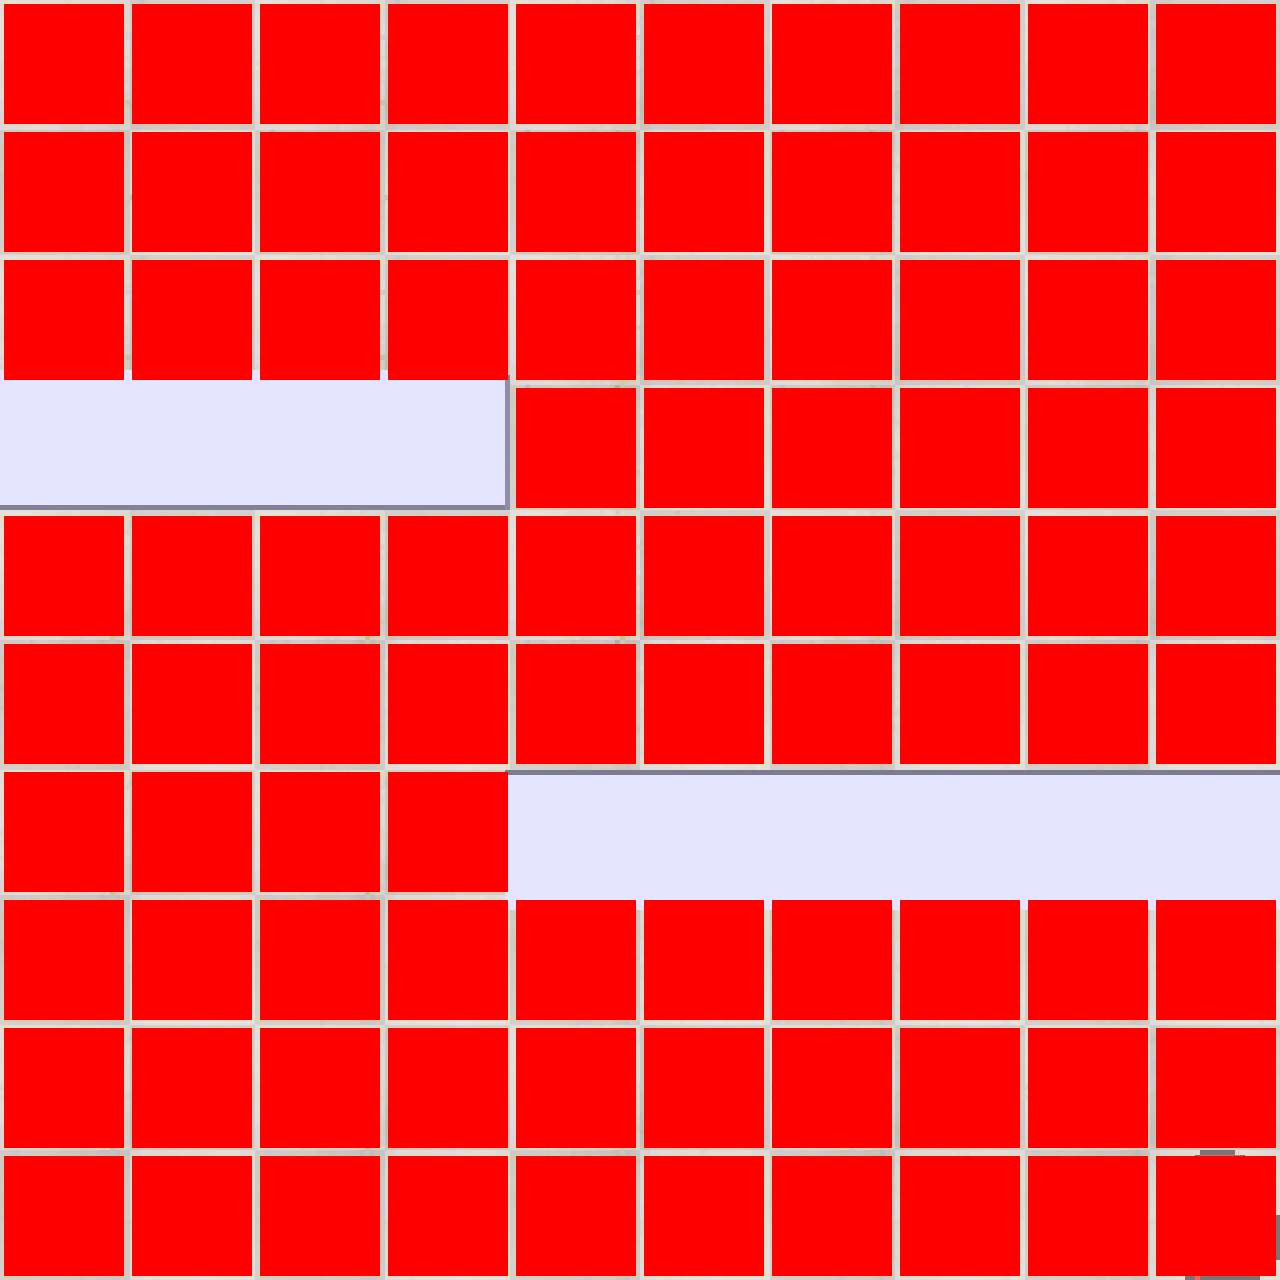

In [168]:
print(parent)
image_pp = Image.fromarray(resized)
image_pp




[1215, 1216]
[64, 64]
[192 192]
[192, 192]
[192, 192]
[320 320]
[320, 320]
[320, 320]
[320 448]
[320, 448]
[320, 448]
[448 576]
[448, 576]
[448, 576]
[576 448]
[576, 448]
[576, 448]
[704 448]
[704, 448]
[704, 448]
[832 448]
[832, 448]
[832, 448]
[960 576]
[960, 576]
[960, 576]
[1088  704]
[1088, 704]
[1088, 704]
[1216  832]
[1216, 832]
[1216, 832]
[1216  960]
[1216, 960]
[1216, 960]
[1216 1088]
[1216, 1088]
[1216, 1088]
[1216 1216]


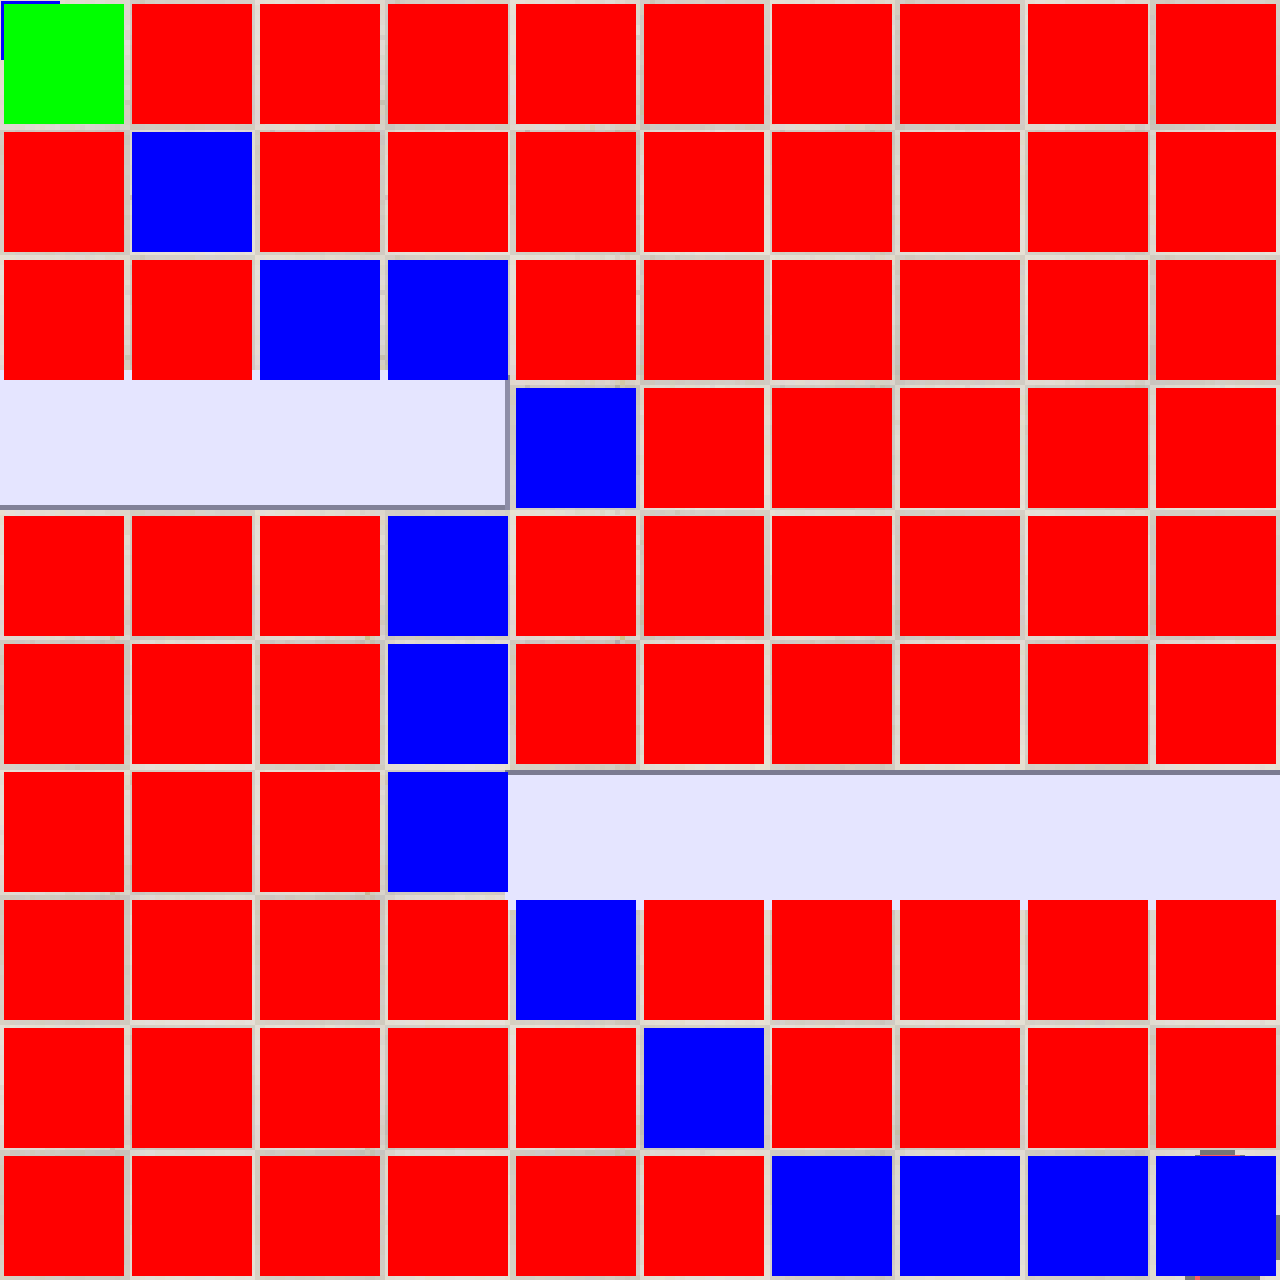

In [171]:
ccc=[]
n=goal
#print(parent[conv(n[0])][conv(n[1])])
print(start)
draw_rec_green(n,resized)
#print(parent[conv(n[0])],parent[conv(n[1])])
while(True):
    print(n)
    a=parent[int(conv(n[0]))][int(conv(n[1]))]
    print(a)
    a1=[a[0],a[1]]
    if a1==[1216,1216]:
        break
    draw_rec_blue(a1,resized)
    n=a1
    print(n)
image_pp = Image.fromarray(resized)
image_pp
